# Plug and Play - Post-Stack Seismic Inversion Example

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import filtfilt
import bm3d
from pylops import Identity, Gradient
from pylops.utils.wavelets import ricker
from pylops.basicoperators import *
from pylops.avo.poststack import *
from pyproximal.proximal import L2, L21
from pnpseismic.DnCNN_models import *
from pnpseismic.Denoising_scalings import *
from pnpseismic.PnP_seismic import *
from matplotlib.colorbar import Colorbar
import matplotlib.gridspec as gridspec

from pylops.optimization.leastsquares import regularized_inversion as RegularizedInversion

np.random.seed(1)
torch.manual_seed(1)
cuda0 = torch.device('cuda:0')

In [2]:
def callback0(x, xtrue, xhist, errhist):
    xhist.append(x)
    errhist.append(np.linalg.norm(x - xtrue)/np.linalg.norm(xtrue))

def callback(x, y, xtrue, xhist, yhist, errhistx, errhisty):
    xhist.append(x)
    yhist.append(y)
    errhistx.append(np.linalg.norm(x - xtrue) / np.linalg.norm(xtrue))
    errhisty.append(np.linalg.norm(y - xtrue) / np.linalg.norm(xtrue))
       
def snr(xref, xest):
    xrefv = np.mean(np.abs(xref) ** 2)
    return 10. * np.log10( xrefv / np.mean(np.abs(xref - xest)**2))

## Synthetic model

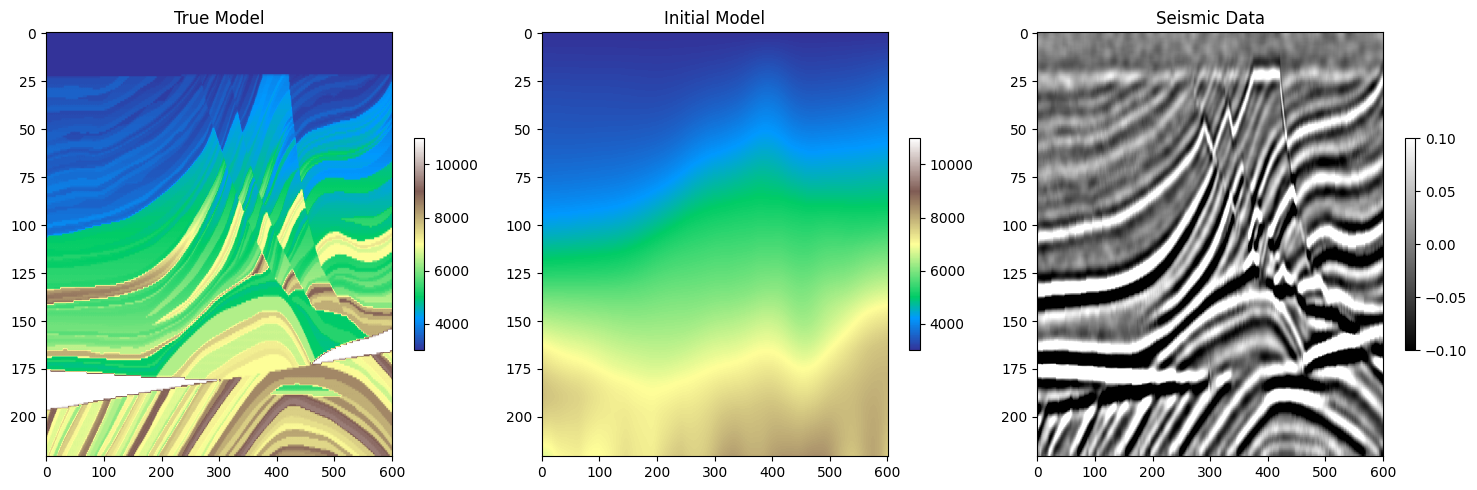

In [3]:
# Synthetic impedance model

nx = 601
nz = 221
velocity_file= '../data/Marm.bin' # true model 
v =(np.fromfile(velocity_file, np.float32)
              .reshape(nz, nx))

den = 2.
m = np.log(v*1000 * den) #m/s*g/cm3
nsmoothz, nsmoothx = 60, 50
mback = filtfilt(np.ones(nsmoothz) / float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx) / float(nsmoothx), 1, mback, axis=1)
mback = mback.copy()

Iop = Identity(m.size)


# Seismic Modeling
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0) * dt0

ntwav = 61
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 15)


# Post-Stack dense operator
PPop_dense = PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True)

# Post-Stack operator
Op = PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

# synthetic noise-free seismic
d = (PPop_dense * m.ravel()).reshape(nz, nx)

# synthetic seismic with colored noise
sigman = 1e-1
n = filtfilt(np.ones(10)/10, 1,
             filtfilt(np.ones(5)/5, 1, np.random.normal(0, sigman, (nz, nx)).T, method='gust').T,
             method='gust')
dn = d + n

# synthetic seismic with Gaussian noise
n2 = np.random.normal(0, 1e-1, d.shape)
dn2 = d + n2

# Scale for the models ploting
vmin, vmax = np.percentile(np.exp(m), [1,99])
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax0=ax[0].imshow(np.exp(m), cmap="terrain" ,vmin=vmin, vmax=vmax)
ax[0].set_title('True Model')
ax[0].axis('tight')
plt.colorbar(ax0, ax=ax[0], shrink=0.5)
ax1=ax[1].imshow(np.exp(mback), cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].set_title('Initial Model')
ax[1].axis('tight')
plt.colorbar(ax1, ax=ax[1], shrink=0.5)
ax2=ax[2].imshow(dn, cmap="gray", vmin=-0.1, vmax=0.1)
ax[2].set_title('Seismic Data')
ax[2].axis('tight')
plt.colorbar(ax2, ax=ax[2], shrink=0.5)
fig.tight_layout()

## L2-Regularized Inversion

In [4]:
# L2 regularized inversion

minv1 = RegularizedInversion(PPop_dense, dn.ravel(), None, 
                            x0=mback.ravel(), epsRs=[0.1],
                            **dict(iter_lim=2000))[0]

minv1 = np.exp(minv1.reshape(nz, nx))


Dop = Laplacian(dims=(nz, nx), dtype=PPop_dense.dtype)
minv2 = RegularizedInversion(PPop_dense, dn.ravel(), [Dop], 
                            x0=mback.ravel(), epsRs=[1], 
                            **dict(iter_lim=2000))[0]
minv2 = np.exp(minv2.reshape(nz, nx))


minv3 = RegularizedInversion(PPop_dense, dn.ravel(), [Dop], 
                            x0=mback.ravel(), epsRs=[1],
                            **dict(iter_lim=2000), damp=0.1)[0]
minv3 = np.exp(minv3.reshape(nz, nx))

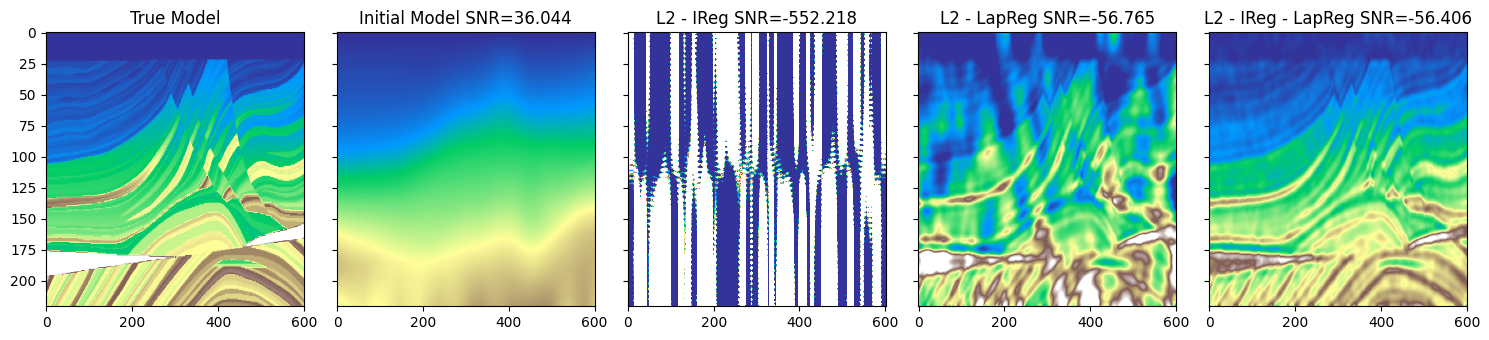

In [5]:
fig, ax = plt.subplots(1,5, figsize=(15,3.5), sharey=True)
ax0=ax[0].imshow(np.exp(m), cmap="terrain" ,vmin=vmin, vmax=vmax)
ax[0].set_title('True Model')
ax[0].axis('tight')

ax1=ax[1].imshow(np.exp(mback), cmap="terrain", vmin=vmin, vmax=vmax)
ax[1].set_title('Initial Model SNR=%.3f' % snr(m, mback))
ax[1].axis('tight')
                
ax2=ax[2].imshow(minv1, cmap="terrain", vmin=vmin, vmax=vmax)
ax[2].set_title('L2 - IReg SNR=%.3f' % snr(m, minv1))
ax[2].axis('tight')
fig.tight_layout()
                
ax2=ax[3].imshow(minv2, cmap="terrain", vmin=vmin, vmax=vmax)
ax[3].set_title('L2 - LapReg SNR=%.3f' % snr(m, minv2))
ax[3].axis('tight')
fig.tight_layout()
                
ax2=ax[4].imshow(minv3, cmap="terrain", vmin=vmin, vmax=vmax)
ax[4].set_title('L2 - IReg - LapReg SNR=%.3f' % snr(m, minv3))
ax[4].axis('tight')
fig.tight_layout()

## TV-Regularized Inversion (PD)

In [17]:
#----------------------------- TV

# L2 proximal Operator
l2 = L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

sigma=0.01 #( = 1/eps )
l1 = L21(ndim=2, sigma=sigma)
Dop = Gradient(dims=(nz, nx), edge=True, dtype=Op.dtype, kind='forward')

L = 8. #np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 1.
mu = 0.99 * tau / L
xerrhisttv = []
xhisttv = []
yerrhisttv = []
yhisttv = []

mpd = PrimalDual(l2, l1, Dop, tau=tau, mu=mu, theta=1., x0=mback.ravel(), niter=100, gfirst=True,
                 callback=lambda xx: callback0(xx, m.ravel(), xhisttv,xerrhisttv))

mpd = np.exp(mpd.reshape(nz, nx))    

## Plug and Play

### Loading Deep Denoisers

In [7]:
# Pre-trained DnCNN 
model_01 = DnCNN_17() 
model_01.load_state_dict(torch.load('../models/model_dict.pth'))
model_01.eval().to(cuda0);

# Pre-trained DRUNet
model_02 = UNetRes(in_nc=2)
# Download drunet_gray.pth from https://drive.google.com/drive/folders/1uEYx0GR4D7q5UMsc1qFVW1KeyVYI_hE-?usp=sharing
# and place it on /models directory
model_02.load_state_dict(torch.load('../models/drunet_gray.pth'))
model_02.eval().to(cuda0);

### PnP using BM3D as denoiser

In [8]:
#--------------------------- BM3D 
l2 = L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)
sigma = 1e-1
denoiser_bm = lambda x, tau: bm3d.bm3d(x, sigma_psd=sigma ,
                                     stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
tau = 10. #/L
mu = .1  #* tau / L
xerrhistbm = []
xhistbm = []
yerrhistbm = []
yhistbm = []
xpnp_bm = PlugAndPlay_PrimalDual(l2, denoiser_bm, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(),
                                               niter=100, mu=mu,
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhistbm, 
                                                                                yhistbm, xerrhistbm, yerrhistbm))

xpnp_bm = np.exp(xpnp_bm.reshape(m.shape))

### PnP using DnCNN and DRUNet as denoisers

In [9]:
#------------------------- DnCNN
l2 = L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

tau = 2. #/L
mu = .005 
denoiser_dn = lambda x, mu_: Denoiser_scale_iter(model_01, torch.from_numpy(x).float(), mu_)
xerrhist01 = []
xhist01 = []
yerrhist01 = []
yhist01 = []
xpnp_dn01 = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(), mu=mu,
                                               niter=100, 
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhist01, 
                                                                                yhist01, xerrhist01, yerrhist01))
xpnp_dn01 = np.exp(xpnp_dn01.reshape(m.shape))

In [10]:
#--------------------------- DRUNET Pre-Trained 

l2 = L2(Op=Op, b=dn.ravel(), x0=mback.ravel(), niter=20, warm=True)

tau = 6. #/L
mu = .1 
sigma = .001
denoiser_dn = lambda x, mu_: scaling_DRUNET(model_02, torch.from_numpy(x).float(), mu_, sigma, verb=False)

xerrhist02 = []
xhist02 = []
yerrhist02 = []
yhist02 = []
xpnp_dn02 = PlugAndPlay_PrimalDual(l2, denoiser_dn, Iop, m.shape,
                                               tau=tau, x0=mback.ravel(), mu=mu,
                                               niter=100, 
                                               callback=lambda xx, yy: callback(xx, yy, m.ravel(), xhist02, 
                                                                                yhist02, xerrhist02, yerrhist02), show=True)
xpnp_dn02 = np.exp(xpnp_dn02.reshape(m.shape))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pnpseismic.PnP_seismic._Denoise'>
Linear operator (A): <class 'pylops.basicoperators.identity.Identity'>
Additional vector (z): None
tau = 6.000000e+00	mu = 1.000000e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   8.00288e+00   2.379e+01   0.000e+00   0.000e+00       2.379e+01
     2   8.00703e+00   8.098e+00   0.000e+00   0.000e+00       8.098e+00
     3   8.01371e+00   5.862e+00   0.000e+00   0.000e+00       5.862e+00
     4   8.01699e+00   5.272e+00   0.000e+00   0.000e+00       5.272e+00
     5   8.01648e+00   5.072e+00   0.000e+00   0.000e+00       5.072e+00
     6   8.01422e+00   4.993e+00   0.000e+00   0.000e+00       4.993e+00
     7   8.01123e+00   4.957e+00   0.000e+00   0.000e+00       4.957e+00
     8   8.00865e+00   4.938

## Results

Comparison of L2 and TV regularized inversions, and PnP with denoisers

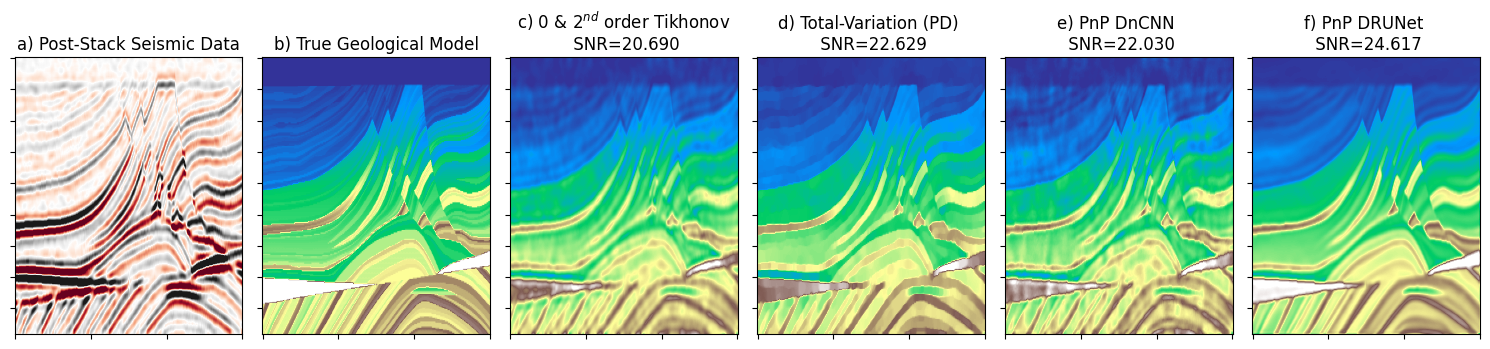

In [18]:
cmap = 'terrain'
plt.rcParams['font.size'] = '10'
vmin, vmax = np.percentile(np.exp(m), [1,99])
fig, ax = plt.subplots(1,6, figsize=(15,3.6))
ax[0].imshow(dn, cmap="RdGy", vmin=-0.2, vmax=0.2)
ax[0].set_title('a) Post-Stack Seismic Data')
ax[0].axis('tight')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([]) 
ax[1].imshow(np.exp(m), cmap=cmap ,vmin=vmin, vmax=vmax)
ax[1].set_title('b) True Geological Model')
ax[1].axis('tight')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([]) 
ax[2].imshow(minv3, cmap=cmap, vmin=vmin, vmax=vmax)
ax[2].set_title('c) 0 & $2^{nd}$ order Tikhonov \n SNR=%.3f' % snr(np.exp(m), minv3))
ax[2].axis('tight')       
ax[2].set_xticklabels([])
ax[2].set_yticklabels([]) 
ax[3].imshow(mpd, cmap=cmap, vmin=vmin, vmax=vmax)
ax[3].set_title('d) Total-Variation (PD) \n SNR=%.3f' % snr(np.exp(m), mpd))
ax[3].axis('tight')
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])        
ax[4].imshow(xpnp_dn01, cmap=cmap, vmin=vmin, vmax=vmax)
ax[4].set_title('e) PnP DnCNN \n SNR=%.3f' % snr(np.exp(m), xpnp_dn01,))
ax[4].axis('tight')
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])     
ax[5].imshow(xpnp_dn02, cmap=cmap, vmin=vmin, vmax=vmax)
ax[5].set_title('f) PnP DRUNet \n SNR=%.3f' % snr(np.exp(m), xpnp_dn02))
ax[5].axis('tight')
ax[5].set_xticklabels([])
ax[5].set_yticklabels([]) 
fig.tight_layout()

# plt.savefig('results_1.eps', format='eps')
# plt.savefig('results_2.png', format='png', dpi=100)

Error convergence curves

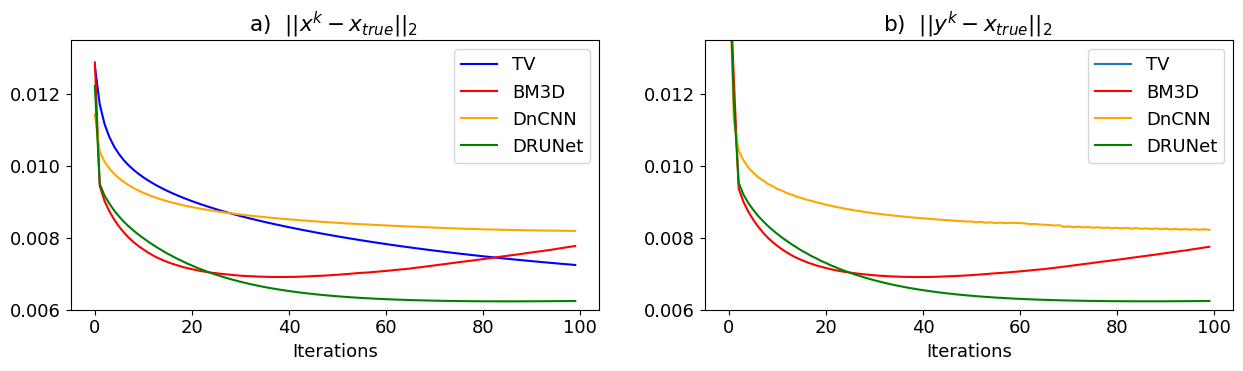

In [19]:
plt.rcParams['font.size'] = '13'
fig, axs = plt.subplots(1, 2, figsize=(15,3.5))
axs[0].plot(xerrhisttv, 'b', label='TV')
axs[0].plot(xerrhistbm, 'r', label='BM3D')
axs[0].plot(xerrhist01, 'orange', label='DnCNN')
axs[0].plot(xerrhist02, 'g', label='DRUNet')
axs[0].set_title(r'a)  $||x^k - x_{true}||_2$ ')
axs[0].set_xlabel('Iterations')
axs[0].set_ylim(0.006, 0.0135)
axs[1].plot(yerrhisttv, label='TV')
axs[1].plot(yerrhistbm, 'r', label='BM3D')
axs[1].plot(yerrhist01,'orange',  label='DnCNN')
axs[1].plot(yerrhist02,'g', label='DRUNet')
axs[1].set_title(r'b)  $||y^k - x_{true}||_2$ ')
axs[1].set_xlabel('Iterations')
axs[1].set_ylim(0.006, 0.0135)
axs[0].legend()
axs[1].legend()
# plt.savefig('error_plot.png', format='png', dpi=100)

Inversion and denoising intermediate steps in PnP-DRUNet

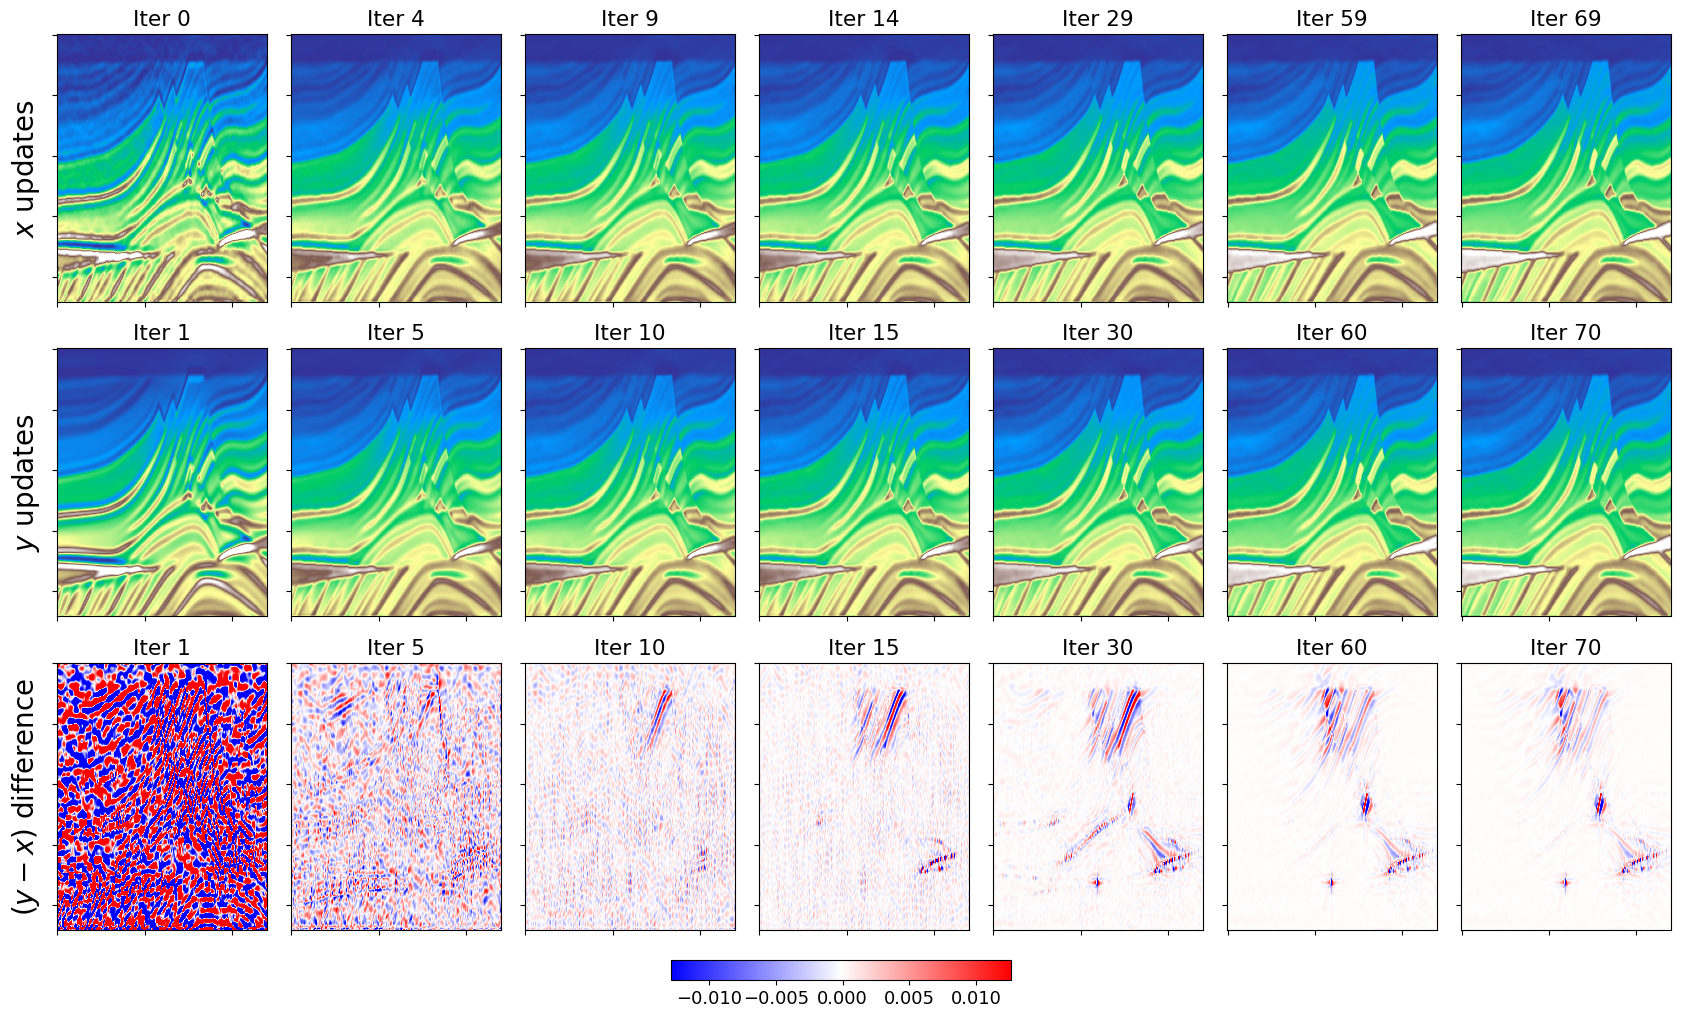

In [13]:
plt.rcParams['font.size'] = '13'

iiter = np.array([0, 4, 9, 14, 29, 59, 69])
fig, axs = plt.subplots(3, 7, sharex=True, sharey=True, figsize=(17,10))
# axs = axs.ravel()
vmin, vmax = np.percentile(np.exp(m), [1,99])
for i, k in zip(range(7), iiter):
    axs[0,i].imshow(np.exp(np.real(xhist02[k]).reshape(m.shape)), vmin=vmin, vmax=vmax, cmap="terrain")
    axs[0,i].set_title('Iter %d' % k)
    axs[0,i].axis('tight')
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
iiter = np.array([1, 5, 10, 15, 30, 60, 70])

vmin, vmax = np.percentile(np.exp(m), [1,99])
for i, k in zip(range(7), iiter):
    axs[1,i].imshow(np.exp(np.real(yhist02[k]).reshape(m.shape)), vmin=vmin, vmax=vmax, cmap="terrain")
    axs[1,i].set_title('Iter %d' % k)
    axs[1,i].axis('tight')
    axs[1,i].set_xticklabels([])
    axs[1,i].set_yticklabels([])
iiter = np.array([1, 5, 10, 15, 30, 60, 70])
vmin, vmax = np.percentile((yhist02[5]-xhist02[4]), [1,99])
for i, k in zip(range(7), iiter):
    axi=axs[2,i].imshow(np.real(yhist02[k]-xhist02[k-1]).reshape(m.shape), vmin=vmin, vmax=vmax, cmap='bwr')
    axs[2,i].set_title('Iter %d' % k)
    axs[2,i].axis('tight')
    axs[2,i].set_xticklabels([])
    axs[2,i].set_yticklabels([])
    
axs[0,0].set_ylabel('$x$ updates', fontsize=20)
axs[1,0].set_ylabel('$y$ updates', fontsize=20)
axs[2,0].set_ylabel('$(y-x)$ difference', fontsize=20)

fig.tight_layout()
fig.subplots_adjust(bottom=0.06)
cbar_ax = fig.add_axes([0.4, 0.01, 0.2, 0.02])
fig.colorbar(axi, cax=cbar_ax, orientation='horizontal')
# plt.savefig('test.png',  bbox_inches='tight')